In [225]:
from langchain_community.document_loaders.csv_loader import CSVLoader
import pandas as pd
import yfinance as yf
from IPython.display import Markdown
from langchain_core.runnables import RunnableConfig
import re
import datetime
from pykrx.stock import get_market_ticker_list, get_market_ticker_name
from langchain_community.agent_toolkits import FileManagementToolkit
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool
from langchain.document_loaders import PyMuPDFLoader, PyPDFLoader
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.tools import tool
from langchain_community.agent_toolkits import FileManagementToolkit
from langchain_core.documents.base import Document
from langchain_core.vectorstores.base import VectorStoreRetriever
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_core.output_parsers.string import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain_experimental.utilities import PythonREPL
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from pydantic import BaseModel, Field
from markitdown import MarkItDown
import dotenv
import os

dotenv.load_dotenv()

True

In [ ]:
class State(TypedDict):
    messages : Annotated[list, add_messages]
    tool_call : Annotated[dict, "tool_call Result"]

In [ ]:
# tools = [TavilySearchResults(), PythonAstREPLTool(), *FileManagementToolkit(
#     selected_tools=["write_file"]).get_tools(),
# ]

In [209]:
root_dir="./files"

In [378]:
llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0.,)

In [463]:
search_tool, code_tool, write_tool = TavilySearchResults(), PythonAstREPLTool(), FileManagementToolkit(selected_tools=["write_file"]).get_tools()[0]

In [465]:
llm_with_tools = llm.bind_tools([search_tool, code_tool])
code_llm = llm.bind_tools([write_tool])

In [468]:
history_checker = llm.with_structured_output(HistoryChecker)
intent_checker = llm.with_structured_output(IntentClassifier)

In [ ]:
class HistoryChecker(BaseModel):
    """
    이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
    답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
    """

    yes_no : Literal["yes", "no"] = Field(..., description="""Use your previous conversation history to determine if you can answer your questions.
    Return "yes" if you can answer, "no" if you can't answer.""")

In [ ]:
def history_check(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
                답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
                
                대화 기록 : {history}
                                          
                질문 : {query}
                                          
                """)
    
    chain = prompt | history_checker

    result = chain.invoke({"history":state["messages"][:-1],
                  "query":state["messages"][-1]})

    return result.yes_no

In [438]:
def memory_chat(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.
                
                대화 기록 : {history}
                                          
                질문 : {query}
                                          
                """)

    
    chain = prompt | llm

    answer = chain.invoke({"history":state["messages"][:-1],
                  "query":state["messages"][-1]})

    return {"messages":answer}

In [467]:
class IntentClassifier:
    """
    당신은 의도 분류 어시스턴트입니다.

    들어온 질문이 어떤 의도를 지닌 질문인지 판단합니다.
    당신은 "code", "tool" 두개 중 하나로만 대답합니다.

    1. code : "문제가 데이터 분석과 관련된 문제일 경우 반환하는 값"
    ### code의 예시
    - 삼성전자의 추세선을 그려주세요.
    - LS의 3월 21일 종가는 얼마인가요?

    2. tool : "문제가 웹 서칭, 파일 관리, 일반 질의에 해당할 경우 반환하는 값"
    ### tool의 예시
    - 한국의 날씨는 어떤가요?
    - 조사한 내용의 레포트 작성해주세요.

    """

    binary : Literal["code", "tool"] = Field(..., description="""You are the intent classification assistant. 
                                             Determine what intention the question is.
                                             You only answer either "code" or "tool".
                                             """)

In [469]:
def intent_check(state:State):

    prompt = PromptTemplate.from_template("""

                당신은 의도 분류 어시스턴트입니다.

                들어온 질문이 어떤 의도를 지닌 질문인지 판단합니다.
                당신은 "code", "tool" 두개 중 하나로만 대답합니다.
                                          
                질문 : {query}
                                          
                """)
    
    chain = prompt | IntentClassifier

    result = chain.invoke({"query":state["messages"][-1]})

    return result.binary

In [ ]:
def select(
    state: State,
):
    try:
        message = state["messages"][-1]
    except:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"이전 대화 기록이 존재하지 않습니다.")
    
    result = llm_with_tools.invoke(message.content)

    if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
        tool_calls = getattr(result, "tool_calls")[0]
        return {"tool_call": tool_calls}
    else:
        return {"tool_call":None}

    

In [440]:
# 주식 DB를 만드는 함수 {"삼성전자":"005930, ... }

def create_stock_db():
    stock_dict = {}
    today = datetime.datetime.today()
    
    stock_list = get_market_ticker_list(today, market="KOSPI")

    for stock in stock_list:
        stock_dict.update({get_market_ticker_name(stock):stock})
    
    stock_list = get_market_ticker_list(today, market="KOSDAQ")

    for stock in stock_list:
        stock_dict.update({get_market_ticker_name(stock):stock})

    return stock_dict

stock_db = create_stock_db()

In [ ]:
def search_stock(query):

    """
    주식 검색 도구입니다.
    결과값으로 데이터프레임이 반환됩니다.
    입력 쿼리에서 주식이름을 추출한 후 모든 주식 데이터를 가져옵니다.
    """


    prompt = PromptTemplate.from_template("""
        당신은 주식 이름 추출기입니다.
        주어진 문장에서 주식이름만 추출하세요.

        ### 예시 1
        query : 삼성전자의 최근 1년에 대해서 분석해주세요.

        answer : 삼성전자

        ### 예시 2
        query : AJ홀딩스우의 최근 실적은 얼마인가요?

        answer : AJ홀딩스우

        ### 입력
        query : {query}

        answer : 

        """
        )
    
    chain = prompt | llm | StrOutputParser()

    stock_name = chain.invoke({"query":query})

    try:
        stock_code = stock_db[stock_name.strip().upper()]   
    except:
        raise ValueError(f"종목명 : {stock_name}을/를 검색할 수 없습니다. 오탈자나 한국거래소에서 거래중인 주식인지 확인해주세요.")
    
    # 예: 삼성전자 (한국거래소는 뒤에 '.KS'를 붙임)
    ticker = yf.Ticker(stock_code+".KS")

    df = ticker.history(period="max") # 기간: '1d', '5d', '1mo', '1y', 'max' 등

    return df.reset_index()

In [ ]:
# tavily_search_results_json, python_repl_ast, read_file, write_file, list_directory

def tools(state:State):
    try:
        name = state["tool_call"]["name"]
    except:
        name = "llm"

    if name == "tavily_search_results_json":

        result = search_tool.invoke(state["tool_call"]["args"]["query"])
        prompt = ChatPromptTemplate.from_messages([
            ("system", """
                        당신은 아래 내용을 이용하여 답변합니다.
                        생각을 담지 말고 사실만을 전달하세요.
                        내용 : {result}

                        """),
            ("human", "{query}")
        ])

        chain = prompt | llm

        answer = chain.invoke({"result":result,
                               "query":state["messages"][-1]})
        
        print(answer)
        
        return {"messages": answer}
    
    elif name == "python_repl_ast":

        title = ""

        if len(code_tool.locals) > 0:
            pass
        else:
            try:
                df = search_stock(state["query"])
            except:
                pass
            

        code = state["tool_call"]["args"]["query"]
        code_tool.invoke(code)

        prompt = ChatPromptTemplate.from_messages([
            ("system", """
                        아래의 코드를 참고하여 질의에 대해 답변합니다.
                        절대 코드에 대해 설명하지마세요.
                        독자는 프로그래머가 아닙니다.
                        데이터 분석과 관련된 코드가 입력된다면 항상 인사이트를 포함하세요.
                        단순 코드는 단순하게 대답합니다.

                        코드 : {code}
             
                        ### 필요하다면 참고할 것

                        title : {title}

                        """),
            ("human", "{query}")
        ])

        chain = prompt | llm

        answer = chain.invoke({"code":code,
                               "title":title,
                               "query":state["messages"][-1]})
        
        return {"messages": answer}    

    elif name =="write_file":
        
        result = state["tool_calls"]["args"]
        
        prompt = PromptTemplate.from_template("""
                    당신은 입력된 정보를 레포트로 만들어내는 역할을 담당하고 있습니다.
                    
                    루트디렉토리의 위치는 "./files/" 입니다. 디렉토리 내부에 파일을 만들어주세요.
                    만들어지는 파일 형태는 .pdf파일이어야합니다.
                                              
                    input : {input}
                    
                    """)

        return write_tool.invoke(result)
    else:
        return {"messages":llm.invoke(state["messages"][-1]).content}

In [454]:
def pretty_print(state:State):

    print(f"\n\n===== Result =====\n\n")

    print(state["messages"][-1].content)

In [455]:
graph = StateGraph(State)

In [456]:
graph.add_node("memory_chat", memory_chat)
graph.add_node("select", select)
graph.add_node("tools", tools)
graph.add_node("pretty_print", pretty_print)

# graph.add_edge(START, "select")
graph.add_conditional_edges(START,
                            history_check,
                            {"yes":"memory_chat",
                             "no":"select"})
graph.add_edge("select", "tools")
graph.add_edge("tools", "pretty_print")
graph.add_edge("memory_chat", "pretty_print")
graph.add_edge("pretty_print", END);

In [457]:
memory = MemorySaver()

app = graph.compile(checkpointer=memory)

In [458]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "1054"})

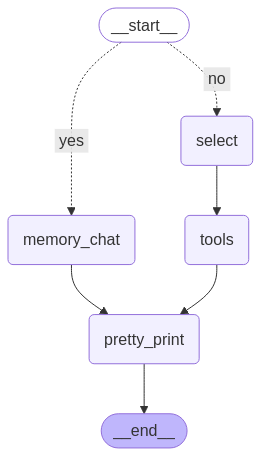

In [435]:
app

In [227]:
result = app.invoke({"messages":("user", "피엔티에 대해 알려주세요.")}, config=config)

content='피엔티에 대해 알려주세요.' additional_kwargs={} response_metadata={} id='33fc80c0-151b-4d7f-ab19-5b120da85c87'
content='피엔티는 롤투롤 컨버팅 기계를 주력으로 성장한 회사입니다. 주요 기술로는 웹가이딩, 장력제어, 오토터렛, 오토스플라이싱, 코팅, 칼렌더링, 슬리팅 등이 있습니다. 이 회사는 디스플레이 소재용 필름, 전자전기 및 2차 전지의 분리막, 음극, 양극 소재 등을 생산하는 장비를 개발하고 있습니다. 또한, IT용 소재와 2차 전지의 음극 및 분리막 소재, Copper 등의 코팅 및 슬리터 장비의 제작 판매를 주요 사업으로 하고 있습니다. \n\n자세한 정보는 다음 링크에서 확인할 수 있습니다:\n- [피엔티 공식 웹사이트](https://www.epnt.co.kr/)\n- [사람인 기업정보](https://www.saramin.co.kr/zf_user/company-info/view/csn/Zm9qNG9WcGt6dlp0RWxvelMrSnVHUT09/company_nm/(%EC%A3%BC)%ED%94%BC%EC%97%94%ED%8B%B0)\n- [삼성전자 기업정보](https://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?gicode=A137400)\n- [나무위키](https://namu.wiki/w/%ED%94%BC%EC%97%94%ED%8B%B0)' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 316, 'prompt_tokens': 714, 'total_tokens': 1030, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens'

In [ ]:
result = app.invoke({"messages":("user", "30+30은 뭐야?")}, config=config)

content='30+30은 뭐야?' additional_kwargs={} response_metadata={} id='e475bd00-b707-4628-9bf1-7d69ed6b0ebd'
content='' additional_kwargs={'tool_calls': [{'id': 'call_8qB2cFwlLqPgDthFKdIdEXAy', 'function': {'arguments': '{"query":"30 + 30"}', 'name': 'python_repl_ast'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 203, 'total_tokens': 223, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-374de99a-2754-453b-a838-e4d17801676b-0' tool_calls=[{'name': 'python_repl_ast', 'args': {'query': '30 + 30'}, 'id': 'call_8qB2cFwlLqPgDthFKdIdEXAy', 'type': 'tool_call'}] usage_metadata={'input_tokens': 203, 'output_tokens': 20, 'total_tokens': 223,

content="import pandas as pd\nimport matplotlib.pyplot as plt\n\ndf = pd.DataFrame({'이름': ['철수', '영희', '민수'], '나이': [20, 21, 19]})\ndf['성인여부'] = df['나이'] >= 20\n\nplt.bar(df['이름'], df['나이'], color='skyblue')\nplt.title('이름별 나이')\nplt.xlabel('이름')\nplt.ylabel('나이')\nplt.show()\n" additional_kwargs={} response_metadata={} id='964ea2e7-b47b-4659-b1dd-ce60a81d0dde'
content='' additional_kwargs={'tool_calls': [{'id': 'call_dVG7iwo1BSZLsqIOxPrhuQVm', 'function': {'arguments': '{"query":"import pandas as pd\\nimport matplotlib.pyplot as plt\\n\\ndf = pd.DataFrame({\'이름\': [\'철수\', \'영희\', \'민수\'], \'나이\': [20, 21, 19]})\\ndf[\'성인여부\'] = df[\'나이\'] >= 20\\n\\nplt.bar(df[\'이름\'], df[\'나이\'], color=\'skyblue\')\\nplt.title(\'이름별 나이\')\\nplt.xlabel(\'이름\')\\nplt.ylabel(\'나이\')\\nplt.show()"}', 'name': 'python_repl_ast'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 133, 'prompt_tokens': 300, 'total_tokens': 433, 'completion_tokens_details': {'acce

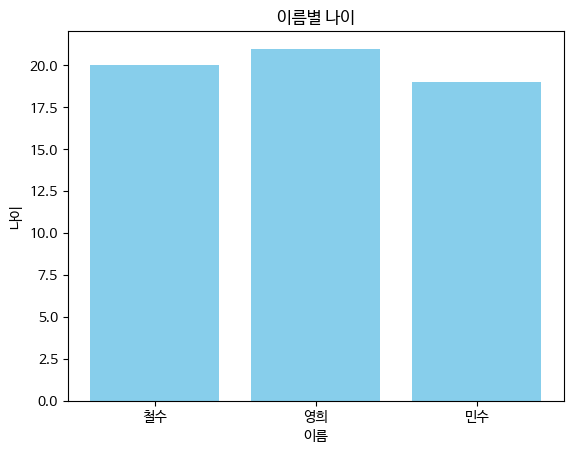

import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'이름': ['철수', '영희', '민수'], '나이': [20, 21, 19]})
df['성인여부'] = df['나이'] >= 20

plt.bar(df['이름'], df['나이'], color='skyblue')
plt.title('이름별 나이')
plt.xlabel('이름')
plt.ylabel('나이')
plt.show()
globals={'__builtins__': {'__name__': 'builtins', '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.", '__package__': '', '__loader__': <class '_frozen_importlib.BuiltinImporter'>, '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>, origin='built-in'), '__build_class__': <built-in function __build_class__>, '__import__': <built-in function __import__>, 'abs': <built-in function abs>, 'all': <built-in function all>, 'any': <built-in function any>, 'ascii': <built-in function ascii>, 'bin': <built-in function bin>, 'breakpoint': <built-in function breakpoint>, 'callable': <built-in function callable>, 'chr'

In [462]:
result = app.invoke({"messages":("user", """import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'이름': ['철수', '영희', '민수'], '나이': [20, 21, 19]})
df['성인여부'] = df['나이'] >= 20

plt.bar(df['이름'], df['나이'], color='skyblue')
plt.title('이름별 나이')
plt.xlabel('이름')
plt.ylabel('나이')
plt.show()
""")}, config=config)

In [461]:
result

{'messages': [HumanMessage(content='피엔티의 30일 추세 그래프 보여줘', additional_kwargs={}, response_metadata={}, id='2017a877-05ba-429d-b9b8-eca5069adc64'),
  AIMessage(content='피엔티의 30일 추세 그래프에 대한 정보는 제공되지 않았습니다. 그러나 피엔티의 주가는 최근 45,800.00원이었으며, 코스닥 증권 거래소에 상장되어 있습니다. 추가적인 세부사항이나 그래프는 해당 링크를 통해 확인할 수 있습니다. \n\n- [피엔티(A137400) | Snapshot | 기업정보 - 삼성전자](https://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?pGB=1&gicode=A137400&cID=&MenuYn=Y&ReportGB=B&NewMenuID=Y&stkGb=701)\n- [피엔티(137400) : 씽크풀](https://m.thinkpool.com/item/137400)\n- [피엔티 137400 코스닥 - 다음 금융](https://finance.daum.net/quotes/A137400)\n- [피엔티 (137400) - 인베스팅닷컴](https://kr.investing.com/equities/people-technology-inc)\n- [44,350 +0.68% | 피엔티](https://alphasquare.co.kr/home/market-summary?code=137400)', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 257, 'prompt_tokens': 765, 'total_tokens': 1022, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens'

In [449]:
result = app.invoke({"messages":("user", "아까 내가 무슨 질문을 했지?")}, config=config)



===== Result =====


아까 하신 질문은 "30+30은 뭐야?"였습니다. 그에 대한 답변은 30 + 30은 60이라는 내용이었습니다.


In [203]:
c.invoke({"history":history})

AIMessage(content='피엔티는 롤투롤 컨버팅 기계의 세계적인 전문가로, 다양한 롤투롤 컨버팅 기계를 주력으로 성장한 회사입니다. 주요 기술로는 웹 가이딩, 장력 제어, 오토 터렛, 오토 스플라이싱, 코팅, 칼렌더링, 슬리팅 등이 있습니다.\n\n회사는 디스플레이 소재용 필름, 전자전기 및 소형 및 ESS용 중대형 2차 전지의 분리막, 음극, 양극 소재, 그리고 회로 소재 및 2차 전지용 극박 등을 생산하는 장비를 개발하고 있습니다.\n\n피엔티의 주요 사업은 IT용 소재, 2차 전지의 음극 및 분리막 소재, Copper 등의 코팅 및 슬리터 장비의 제작 및 판매입니다.\n\n자세한 정보는 다음 링크에서 확인할 수 있습니다:\n- [피엔티 공식 웹사이트](https://www.epnt.co.kr/)\n- [사람인 기업정보](https://www.saramin.co.kr/zf_user/company-info/view/csn/Zm9qNG9WcGt6dlp0RWxvelMrSnVHUT09/company_nm/(%EC%A3%BC)%ED%94%BC%EC%97%94%ED%8B%B0)\n- [삼성전자 기업정보](https://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?gicode=A137400)\n- [나무위키](https://namu.wiki/w/%ED%94%BC%EC%97%94%ED%8B%B0)', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 353, 'prompt_tokens': 654, 'total_tokens': 1007, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details':